# Integrate-and-fire neuron basics

Here, we will go over the basic spiking neuron model, the integrate-and-fire neuron. We will be using the [Brian2](https://briansimulator.org/) simulator for designing the networks and experiments. 


In [1]:
from pylab import *
from brian2 import *
import time

In [2]:
%matplotlib inline

plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'text.usetex': True})
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}']
plt.rcParams.update({'font.family': 'serif', 
                     'font.serif':['Computer Modern']})

WARNING    /var/folders/xn/hqbqng2d6nz8f1lcyd545kqr0000gn/T/ipykernel_16537/3957815523.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [
 [py.warnings]


One aspect of Brian2 that I really appreciate is its use of actual physical units, and the unit checking engine. Sometimes this type of thing can be frustrating, but the system makes sure that you don't make mistakes and helps with debugging. As well, it is generally useful to remember the units and it helps better understand the physical relationships to the dynamical equations in the simulation.

To that end, we are modeling neurons using the classic integrate-and-fire neuron model. Thus, we will also use physical units that are close to appropriate for biology. When we model biological neurons, we actually use the abstraction of electronic circuits, which means that our simulation uses Maxwell's equations. 

In [3]:

# Neuron parameters
C_Ax = 2.0 * nF # Capacitance of action-potential compartment
C_Sh = 2.0 * nF # Capacitance of shunt compartment
C_in = 1.0 * nF # Capacitance of inhibitory cells

g_c = 55.0 * nS # Coupling conductance
g_l =  5.0 * nS # leak conductance

E_l = -60.0 * mV # Resting potential
E_i = -60.0 * mV # Shunting reversal potential

V_t = -58.0 * mV # Threshold
V_r = -62.0 * mV # Reset

tau_e = 10.0 * ms # Excitatory time-constant.
tau_i = 100.0 * ms # Shunting inhibition time-constant.

eqs_1 = Equations('''
    dV/dt = (g_l * (E_l - V) + I_ext + I_rec) / C_Ax : volt (unless refractory)
    I_ext : amp
    I_rec : amp
    ''')

# The principal cells and inhibitory neurons are based on the two-compartment model
# for now the gi (shunting inhibition) variable is set to constant.
eqs_2 = Equations('''
    dV/dt = (g_l * (E_l - V) + g_c * (Vs - V)) / C_Ax : volt  (unless refractory)
    dVs/dt = (g_l * (E_l - Vs) + g_c * (V - Vs) + gi * (E_i - Vs) + Id + I_ext + I_rec) / C_Sh : volt 
    dId/dt = -Id/tau_e : amp
    dgi/dt = -0.0 * gi/tau_i : siemens
    I_ext : amp
    I_rec : amp
    ''')

# The principal cells and inhibitory neurons are based on the two-compartment model
eqs_2_in = Equations('''
    dV/dt = (g_l * (E_l - V) + g_c * (Vs - V)) / C_Ax : volt (unless refractory)
    dVs/dt = (g_l * (E_l - Vs) + g_c * (V - Vs) + gi * (E_i - Vs) + Id + I_ext + I_rec) / C_in : volt
    dId/dt = -Id/tau_e : amp
    dgi/dt = -gi/tau_i : siemens
    I_ext : amp
    I_rec : amp
    ''')

## I&F neuron theory

The integrate-and-fire neuron model has a nearly linear input-output function, and the slope and offset of this line can be determined directly from the parameters of the model. If we just focus on the axon compartment (i.e. the compartment that has the spiking mechanism), then we can compute the firing rate analytically.

This is done by computing the time it takes to reach threshold from the reset potential when given a constant current reaching the axon, $I_s$. This time is given by:
$$
T_{spike} = \frac{C_{Ax}}{g_l} \log \Big( \frac{I_s + g_l (E_l - V_r)}{I_s + g_l (E_l - V_{\theta})} \Big) + \tau_{ref}
$$

The \emph{instantaneous-firing-rate} (IFR) is the inverse of $T_{spike}$:
$$
IFR = 1 / T_{spike}
$$

If the refractory period $\tau_{ref}$ is 0, then the IFR approaches a straight line for large input currents. 

Linear apporximation of firing rate:

$$
IFR = m I_s + b
$$

$$
m = \frac{1.0}{C_{Ax} (V_{\theta} - V_{r})}
$$

$$
b = \frac{-g_l ((V_{\theta} - E_l) + (V_{r} - E_l))}{2C_{Ax} (V_{\theta} - V_{r})}
$$

So if the threshold and the reset are equal voltages different from the resting potential, then the offset will be 0. This is useful for true gain control.


In [9]:
print "slope:", 1.0 *nA / (C_Ax * (V_t - V_r)), "offset:", -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))

slope: 125. Hz offset: -0. Hz


Finally, the two compartment model can support multiplicative gain control. The gain factor, $\Gamma I_d = I_s$, where $I_d$ is the dendritic input current, determines the ratio of the current that reaches the axon compartment and creates a spike:

Gain factor:

$$
\Gamma = \frac{g_c}{g_l + g_c + g_{i}}
$$

In [10]:
print "gain:", g_c / (g_l + g_c)

gain: 0.916666666667


The linear function of firing rate is only linear when there is no refractory period. Here we compare the linear approximation of the firing rate to the more detailed firing rate computation. 

figures/ifr-refractory-Vr=-62-Vt=-58-n180814


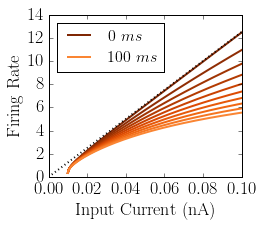

In [14]:
figure(figsize=(4,3.5))

Ish = np.linspace(0, 0.1, 500) * nA

test_tref = np.linspace(0, 100, 10) * ms

cols = get_cmap('Oranges_r', len(test_tref)+10)

for itref,tref in enumerate(test_tref):

    t_spike = C_Ax / g_l * np.log((Ish + g_l*(E_l - V_r))/(Ish + g_l*(E_l - V_t))) + tref
    
    if itref == 0 or itref==(len(test_tref)-1):
        plot(Ish/nA, 1/t_spike / second, lw=2, c=cols(itref), label=r"$%i \ ms$"%(tref/ms))
    else:
        plot(Ish/nA, 1/t_spike / second, lw=2, c=cols(itref))

    
m_ifr = 1 / (C_Ax * (V_t - V_r))
b = -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))

plot(Ish/nA, (m_ifr * Ish + b), ':k', lw=2)

xlim([0, Ish[-1]/nA])

legend(loc='upper left', fontsize=16)

xlabel('Input Current (nA)')
ylabel('Firing Rate')

plt.tight_layout()

fname = ('figures/ifr-refractory-Vr=' + str(int(V_r/mV)) + '-Vt=' + str(int(V_t/mV))
          + '-n' + time.strftime('%y%m%d'))

print fname
savefig(fname + '.png', format='png')
savefig(fname + '.eps', format='eps')  

The firing rates with a refractory period then saturate to $IFR = 1/\tau_{ref}$.

# Simulations compared to theory

Now, we are going to simulate the network and compute the firing rate for a steady current injection. This should be comparable to the theory above, and the firing rate should approach the line of the theory.

In [6]:
N_s = 50
tref=0*ms
G_post = NeuronGroup(N_s, model=eqs_1, threshold='V>V_t', reset='V=V_r', refractory=tref)

G_post.V = E_l * ones(N_s)
#G_post.Vs = E_l * ones(N_s)
G_post.I_ext = np.linspace(0.0, 0.2, N_s) * nA

SpM_post = SpikeMonitor(G_post)

StM_post = StateMonitor(G_post, True, record=True)

ifr_net = Network()
ifr_net.add(G_post)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

In [7]:

run_time = 1.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print "elapsed", time.time() - tst

INFO       No numerical integration method specified for group 'neurongroup', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]


elapsed 1.25455594063


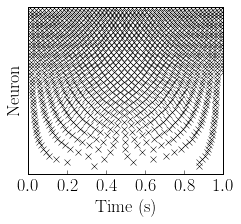

In [8]:

post_spikes = SpM_post.spike_trains()
ifr = np.zeros(N_s)

figure(figsize=(3.5,3))

for i in range(len(post_spikes)):
    plot(post_spikes[i] / second, i * ones(len(post_spikes[i])), 'xk')
    
    if len(post_spikes[i]) > 1:
        ifr[i] = 1.0 / np.mean(np.diff(post_spikes[i]))
    
ylim([0-0.5, N_s-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

(0, 0.2)

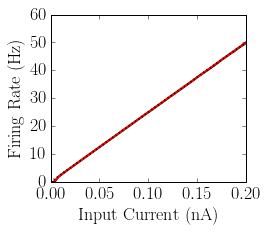

In [9]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, ifr / second, 'k', lw=2)

gain = g_c / (g_l + g_c)

Ia = Id # for 1 compartment 
#Ia =  Id * gain # for 2 compartment

t_spike = C_Ax / g_l * np.log((Ia+g_l*(E_l - V_r))/(Ia+g_l*(E_l - V_t))) + tref

plot(Id/nA, 1/t_spike / second, lw=2, c='r')


#Ish = np.linspace(0, G_post.I_ext[-1]/nA, 500) * nA

m_ifr = 1 / (C_Ax * (V_t - V_r))
b = -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))

plot(Id/nA, (m_ifr * Ia + b), ':k', lw=2)


xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])


In [10]:
N_s = 50
tref=20*ms
G_post = NeuronGroup(N_s, model=eqs_1, threshold='V>V_t', reset='V=V_r', refractory=tref)

G_post.V = E_l * ones(N_s)
#G_post.Vs = E_l * ones(N_s)
G_post.I_ext = np.linspace(0.0, 0.2, N_s) * nA

SpM_post = SpikeMonitor(G_post)

StM_post = StateMonitor(G_post, True, record=True)

ifr_net = Network()
ifr_net.add(G_post)
ifr_net.add(SpM_post)
ifr_net.add(StM_post)

ifr_net.store('init')

In [11]:

run_time = 1.0 * second
ifr_net.restore('init')
tst = time.time()
ifr_net.run(run_time)
print "elapsed", time.time() - tst

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'linear' (took 0.06s). [brian2.stateupdaters.base.method_choice]


elapsed 1.02112698555


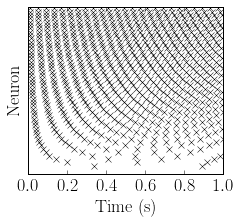

In [12]:

post_spikes = SpM_post.spike_trains()
ifr = np.zeros(N_s)

figure(figsize=(3.5,3))

for i in range(len(post_spikes)):
    plot(post_spikes[i] / second, i * ones(len(post_spikes[i])), 'xk')
    
    if len(post_spikes[i]) > 1:
        ifr[i] = 1.0 / np.mean(np.diff(post_spikes[i]))
    
ylim([0-0.5, N_s-0.5])
xlim([0, run_time/second])
yticks([])
xlabel('Time (s)')
ylabel('Neuron')

(0, 0.2)

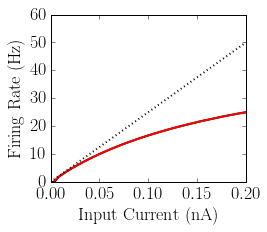

In [13]:
figure(figsize=(3.5,3))

Id = G_post.I_ext

plot(Id / nA, ifr / second, 'k', lw=2)

gain = g_c / (g_l + g_c)

Ia = Id # for 1 compartment 
#Ia =  Id * gain # for 2 compartment

t_spike = C_Ax / g_l * np.log((Ia+g_l*(E_l - V_r))/(Ia+g_l*(E_l - V_t))) + tref

plot(Id/nA, 1/t_spike / second, lw=2, c='r')


#Ish = np.linspace(0, G_post.I_ext[-1]/nA, 500) * nA

m_ifr = 1 / (C_Ax * (V_t - V_r))
b = -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))

plot(Id/nA, (m_ifr * Ia + b), ':k', lw=2)


xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Id[-1]/nA])


# Delay mechanisms for spiking FHRR

With the current to spike rate under control, we can now implement the synaptic delay mechanisms and balanced inhibition to create the basis of the spiking FHRR code. 

In [14]:
s_delay = 0
s_c_freq = (2*np.pi* (5.0)) / second
s_c_damp = 15 / second

s_delay_model = '''
mag : 1
I_ext_post = sx * nA : amp (summed)
dsx/dt = -s_c_freq * sx : 1 (clock-driven)
'''
s_delay_inh = '''
mag : 1
I_rec_post = sx * nA : amp (summed)
dsx/dt = -0.5*s_c_freq * sx : 1 (clock-driven)
'''
s_delay_on_pre = '''
sx += mag
'''

In [15]:
syn_delay = 100*ms
phase_shift = syn_delay * s_c_freq
#z_phase = np.cos(phase_shift) + 1.0j * np.sin(phase_shift)
#pmat = pmat * z_phase

In [16]:
N_s = 4
N_i = 1

spike_indices = [0, 1, 2, 3]
spike_times = [250*ms, 200*ms, 150*ms, 100*ms]; time_tag = 'reverse'

# spike_indices = [0, 1, 2, 3, 0, 1, 2, 3]
# spike_times = [250*ms, 200*ms, 150*ms, 100*ms,
#                450*ms, 400*ms, 350*ms, 300*ms]; time_tag = 'double'

# spike_indices = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
# spike_times = [250*ms, 200*ms, 150*ms, 100*ms,
#                450*ms, 400*ms, 350*ms, 300*ms,
#                650*ms, 600*ms, 550*ms, 500*ms,]; time_tag = 'triple'

#spike_times = [100*ms, 125*ms, 150*ms]; time_tag = 'forward'

#spike_indices = [0]
#spike_times = [125*ms]; time_tag = 'sync'


#G_pre = NeuronGroup(N_pre, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_pre = SpikeGeneratorGroup(N_s, spike_indices, spike_times)
G_inh = NeuronGroup(N_i, model=eqs_2_in, threshold='V>V_t', reset='V=V_r', refractory=0*ms)
G_post = NeuronGroup(N_s, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=100*ms)

G_post.V = E_l * ones(N_s)
G_post.Vs = E_l * ones(N_s)
G_post.I_ext = 0

G_inh.V = E_l * ones(N_i)
G_inh.Vs = E_l * ones(N_i)
G_inh.I_ext = 0.0 * nA

S_pre_post = Synapses(G_pre, G_post, s_delay_model, on_pre=s_delay_on_pre, method='euler')
S_pre_inh = Synapses(G_pre, G_inh, s_delay_inh, on_pre=s_delay_on_pre, method='euler')
S_inh_post = Synapses(G_inh, G_post, s_delay_inh, on_pre=s_delay_on_pre, method='euler')

#S_pre_post.connect(j='i')
S_pre_post.connect()
S_pre_post.mag = 0.3

sync_phase = -np.pi/4

delay_vec =  1./s_c_freq * (np.array(
                   [np.pi, np.pi/2 + sync_phase, np.pi,   np.pi/2,
                    np.pi, np.pi + sync_phase,    np.pi/2, np.pi/2,
                    np.pi, 3*np.pi/2 + sync_phase, 2*np.pi,       np.pi/2,
                    np.pi, 2*np.pi + sync_phase,        2*np.pi,       np.pi/2]))

S_pre_post.delay = delay_vec + 2*np.pi/4/s_c_freq

S_pre_inh.connect()
S_pre_inh.mag = 0.3
S_pre_inh.delay = np.pi/2/s_c_freq

S_inh_post.connect()
S_inh_post.mag = -0.033

#S_pre_post.sx = 1
#S_pre_post.sv = 0

#S_pre_post.delay=syn_delay

#SpM_pre = SpikeMonitor(G_pre)
SpM_post = SpikeMonitor(G_post)
SpM_inh = SpikeMonitor(G_inh)
StM_S = StateMonitor(S_pre_post, True, record=True)

#StM_pre = StateMonitor(G_pre, True, record=True)
StM_post = StateMonitor(G_post, True, record=True)

In [17]:
envelope_net = Network()
envelope_net.add(G_pre)
envelope_net.add(G_inh)
envelope_net.add(G_post)

envelope_net.add(S_pre_post)
envelope_net.add(S_pre_inh)
envelope_net.add(S_inh_post)

#complex_net.add(SpM_pre)
envelope_net.add(SpM_post)
envelope_net.add(SpM_inh)
envelope_net.add(StM_post)

envelope_net.add(StM_S)

envelope_net.store('init')

In [18]:
run_time = 0.8 * second
#run_time = 1.0 * second
envelope_net.restore('init')
tst = time.time()
envelope_net.run(run_time)
print "elapsed", time.time() - tst

INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.04s, trying other methods took 0.10s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.03s, trying other methods took 0.09s). [brian2.stateupdaters.base.method_choice]


elapsed 2.65714788437


In [19]:
inh_spikes = SpM_inh.spike_trains()


figures/syn_dyn-demo2m-Vs-step-reverse-N=4-w=5-ll=15-n180725


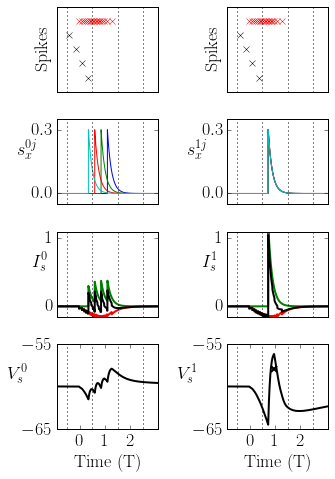

In [20]:
figure(figsize=(5,7))

tt_st = 0.08

sp_tr = SpM_post.spike_trains()

for iN, Ni in enumerate([0,1]):
    sii = np.arange(Ni, N_s**2, N_s)

    subplot(4, 2, iN+1)
    plot(spike_times / second, spike_indices,'xk')
    plot(inh_spikes[0]/second, len(inh_spikes[0])*[4], 'xr')
    xticks([])
    #yticks(arange(N_s))
    yticks([])
    xlim([0, run_time/second])
    ylim([-1, N_s+1])
    ylabel('Spikes')
    
    for tti in range(5):
        plot([tt_st+0.2*tti, tt_st+0.2*tti], [-1, N_s+1], ':k')


    subplot(4, 2, iN+3)
    plot(StM_S.t / second, StM_S.sx[sii, :].T)
    xlim([0,  run_time/second])
    xticks([])
    yticks([ 0, .3])
    ylim([-.05, .35])
    ylabel('$s_x^{%ij}$'%Ni, rotation=0)
    
    for tti in range(5):
        plot([tt_st+0.2*tti, tt_st+0.2*tti], [-.1, .5], ':k')
        
        
    subplot(4, 2, iN+5)
    plot(StM_post.t / second, StM_post.I_ext[Ni, :].T/nA, 'g', lw=2)
    plot(StM_post.t / second, StM_post.I_rec[Ni, :].T/nA, 'r', lw=2)     
    plot(StM_post.t / second, StM_post.I_ext[Ni, :].T/nA + StM_post.I_rec[Ni, :].T/nA, 'k', lw=2)

    xlim([0,  run_time/second])
    #xticks(linspace(0, run_time/second, 5))
    ylim([-.15, 1.1])
    yticks([ 0,   1])
    #xlabel('Time (T)')
    ylabel('$I_s^{%i}$'%Ni, rotation=0)
    xticks([])
    
    for tti in range(5):
        plot([tt_st+0.2*tti, tt_st+0.2*tti], [-.15, 1.1], ':k')
    

    #xticks(arange(tt_st+0.1, 0.7, 0.2), ['$0$', '$1$', '$2$', '$3$']);

    
    subplot(4, 2, iN+7)
    plot(StM_post.t / second, StM_post.Vs[Ni, :].T/mV, 'k', lw=2)
    #plot(StM_post.t / second, StM_post.V[Ni, :].T/mV, 'k', lw=2)
    
    plot(sp_tr[Ni], len(sp_tr[Ni]) *[-58], 'xk', mew=2)

    xlim([0,  run_time/second])
    #xticks(linspace(0, run_time/second, 3))
    xticks(arange(tt_st+0.1, 0.7, 0.2), ['$0$', '$1$', '$2$', '$3$']);

    ylim([-65, -55])
    yticks([-65,-55])
    xlabel('Time (T)')
    ylabel('$V_s^{%i}$'%Ni, rotation=0)

    
    for tti in range(5):
        plot([tt_st+0.2*tti, tt_st+0.2*tti], [-100, -40], ':k')
    


    
plt.tight_layout()

fname = ('figures/syn_dyn-demo2m-Vs-step-' + time_tag + '-'
         + 'N=' + str(N_s) + '-w=' + str(int(s_c_freq/2/np.pi)) + '-ll=' + str(int(s_c_damp))
         + '-n' + time.strftime('%y%m%d'))

print fname
savefig(fname + '.png', format='png')
savefig(fname + '.eps', format='eps')  

# Gain control

Finally, a potentially important mechanism is to have direct gain modulation. This is tricky in spiking neurons. However, it can be done with shunting inhibition, but only in a two-compartment model neuron. 

This requires a conductance-based synapse.

In [21]:
N_s = 50

test_gi = np.array([0, 25, 50, 100])

I_ext_all = np.linspace(0.0, 0.5, N_s)
post_spikes_all = []

for i, giv in enumerate(test_gi):
    G_post = NeuronGroup(N_s, model=eqs_2, threshold='V>V_t', reset='V=V_r', refractory=0*ms)

    G_post.V = E_l * ones(N_s)
    G_post.Vs = E_l * ones(N_s)
    G_post.I_ext = I_ext_all * nA
    G_post.gi = giv * ones(N_s) * nS

    SpM_post = SpikeMonitor(G_post)

    StM_post = StateMonitor(G_post, True, record=True)

    ifr_net = Network()
    ifr_net.add(G_post)
    ifr_net.add(SpM_post)
    ifr_net.add(StM_post)

    ifr_net.store('init')
    
    run_time = 1.0 * second
    ifr_net.restore('init')
    tst = time.time()
    ifr_net.run(run_time)
    print "elapsed", time.time() - tst
    
    post_spikes = SpM_post.spike_trains()

    post_spikes_all.append(post_spikes)

INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


elapsed 1.35653400421


INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


elapsed 1.257999897


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


elapsed 1.20347881317
elapsed 1.19171214104


In [22]:
ifr = np.zeros((N_s, len(test_gi)))

for ps in range(len(post_spikes_all)):
    post_spikes = post_spikes_all[ps]
    for i in range(len(post_spikes)):
        if len(post_spikes[i]) > 1:
            ifr[i, ps] = 1.0 / np.mean(np.diff(post_spikes[i]))

(0, 0.5)

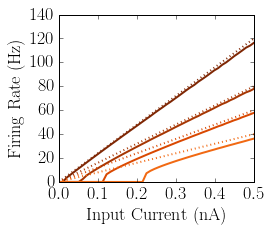

In [23]:
figure(figsize=(3.5,3))

cols = get_cmap('Oranges_r', len(post_spikes_all)+5)

for ps in range(len(post_spikes_all)):

    plot(I_ext_all, ifr[:, ps] / second, c=cols(ps), lw=2)


    Ish = np.linspace(0, I_ext_all[-1], 500) * nA
    gain = g_c / (g_l + g_c + test_gi[ps] * nS)
    m_ifr = 1 / (C_Ax * (V_t - V_r))
    b = -g_l * (V_t + V_r - 2 * E_l) / (2*C_Ax * (V_t - V_r))

    plot(Ish/nA, (gain * m_ifr * Ish + b), ':', c=cols(ps), lw=2)


xlabel('Input Current (nA)')
ylabel('Firing Rate (Hz)')
xlim([0, Ish[-1]/nA])